In [1]:
import numpy as np
import math
from collections import Counter
from sklearn.datasets import load_digits
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline 
from matplotlib import pyplot as plt

In [2]:
def softmax(x):
    # softmax function – input is array, returns softmax probability vector
    return (np.exp(x.T - np.max(x) ) / (np.sum(np.exp(x - np.max(x)), axis=1))).T


def loss_function(s, y_actual):
    # s is the output of softmax; y_actual is the encoded target y variable
    cross_entropy_error = np.sum(np.log(s) * y_actual, axis=1)
    return cross_entropy_error


def cross_entropy_gradient(x, s, y):
    
    # one-hot encode target variables
    y = np.array([[1 if i == y[j] else 0 for i in range(10)] 
                  for j in range(len(y))])
    # compute gradient
    g = np.matmul(x.T, (s - y))
    # normalize
    g = g / np.linalg.norm(g)  
    return g


def train(x_train, y_train, lr, num_iters, reg):
    weights = .01 * np.random.randn(x_train.shape[1], 10)
    losses = []
    # one-hot encode target variables
    y = np.array([[1 if i == y_train[j] else 0 for i in range(10)] 
                  for j in range(len(y_train))])
    for i in range(num_iters):
        # compute scores, put into softmax in order to compute loss gradient
        z = x_train.dot(weights)
        s = softmax(z)
        grad = cross_entropy_gradient(x_train, s, y_train)
        loss = loss_function(s, y)
        # update weights against direction of gradient, with regularization term
        weights -= (lr * grad) - (reg * 1/(np.linalg.norm(weights)**2))
        # for plotting purposes, keep track of mean cross-entropy losses
        losses.append(np.mean(loss))

    return weights, losses


def predict(x_test, y_test, weights):
    z = x_test.dot(weights)
    s = softmax(z)
    # predicted class is argmax of softmax-output vector
    predictions = s.argmax(axis=1)
    accuracies = 0
    # count fraction of correct predictions
    for i, p in enumerate(predictions):
        if p == y_test[i]:
            accuracies += 1
    accuracy = accuracies / len(y_test)
    return accuracy


In [3]:
# computing features
def compute_x_symmetry(img):
    # transform cell (i, j) |--> (i, #cols - j)
    img_reflected = np.fliplr(img)
    # compute symmetry as magnitude of vector of element-wise difference between matrices
    # normalized by max possible pixel intensity
    x_symmetry = np.subtract(img, img_reflected) / 16
    x_symmetry = np.linalg.norm(x_symmetry.flatten())
    return x_symmetry


def compute_y_symmetry(img):
    # transform cell (i, j) |--> (#rows - i, j)
    img_reflected = np.flipud(img)
    # compute symmetry as magnitude of vector of element-wise difference between matrices
    # normalized by max possible pixel intensity
    y_symmetry = np.subtract(img, img_reflected) / 16
    y_symmetry = np.linalg.norm(y_symmetry.flatten())
    return y_symmetry

def compute_density(img):
    # density is calculated simply the average of all pixel intensities
    density = np.sum(img.flatten()) / 64
    return density


## Experiments with digits dataset

In [4]:
data = load_digits()

def feature_engineering(X_train=data):

    # doing feature engineering – compute x symmetries, y symmetries, and density for each image
    x_symmetries = {x: 0 for x in range(0, 10)}
    y_symmetries = {y: 0 for y in range(0, 10)}
    densities = {z: 0 for z in range(0, 10)}

    # we will create a list of triples of features (represented as a list (of length 1797) of lists (of length 3))
    feature_list = []
    
    for i, img in enumerate(X_train.images):
        
        rx = compute_x_symmetry(img)
        x_symmetries[X_train.target[i]] += rx

        ry = compute_y_symmetry(img)
        y_symmetries[X_train.target[i]] += ry
    
        density = compute_density(img)
        densities[X_train.target[i]] += density
    
        feature_list.append([rx, ry, density])
    
    feature_array = np.array(feature_list)
        
    targets_count = Counter(X_train.target)
    
    for i in range(10):
        # normalize features
        x_symmetries[i] /= targets_count[i]
        y_symmetries[i] /= targets_count[i]
        densities[i] /= targets_count[i]
        
    # we would like to transform this into a 20-dimensional feature space. 
    # do this via cubic transform. don't forget to scale down features
    cubic = PolynomialFeatures(3)
    transformed_feature_array = cubic.fit_transform(feature_array)/100
    
    avg_features = list(zip(x_symmetries.values(), y_symmetries.values(), densities.values()))
    avg_features = np.array([np.array([x, y, z]) for (x,y,z) in avg_features])
    transformed_avg_features = cubic.fit_transform(avg_features)
    
    return transformed_avg_features, transformed_feature_array

taf, tfa = feature_engineering()

[0.3333333333333333, 0.2972222222222222, 0.2785515320334262, 0.3732590529247911, 0.3816155988857939]
[0.3333333333333333, 0.30277777777777776, 0.2785515320334262, 0.362116991643454, 0.37047353760445684]
[0.3277777777777778, 0.30277777777777776, 0.2785515320334262, 0.3732590529247911, 0.37047353760445684]
[0.3277777777777778, 0.2972222222222222, 0.2618384401114206, 0.3732590529247911, 0.3816155988857939]


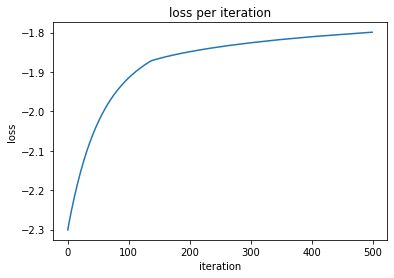

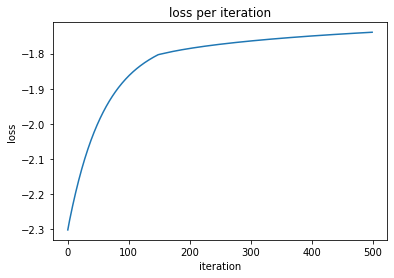

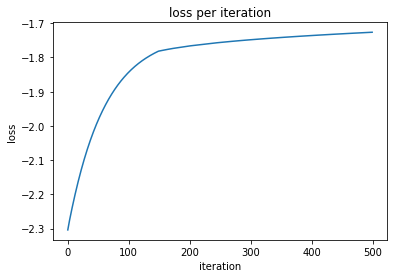

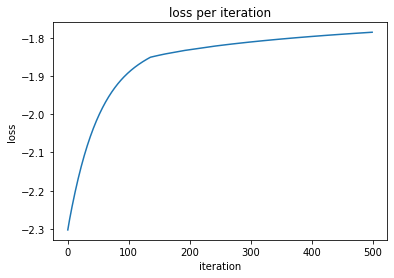

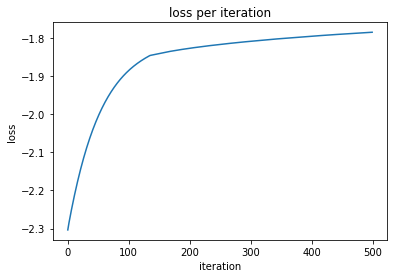

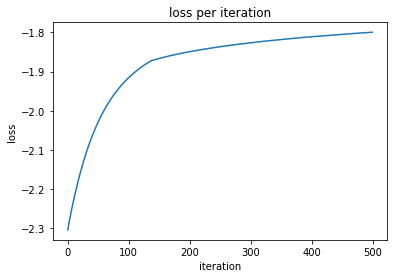

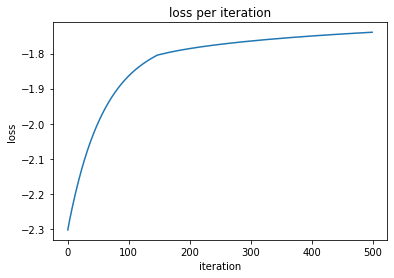

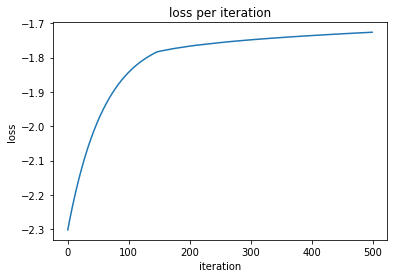

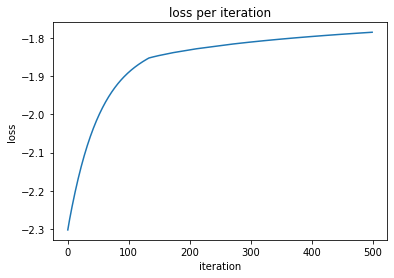

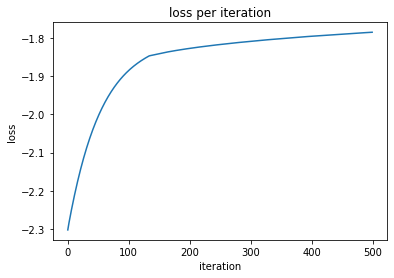

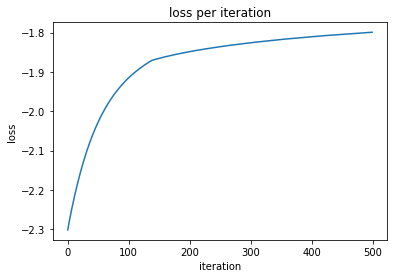

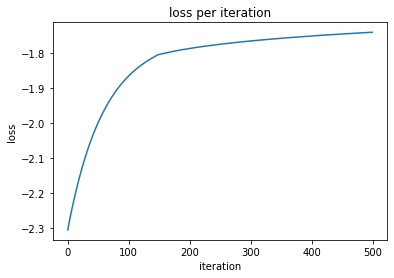

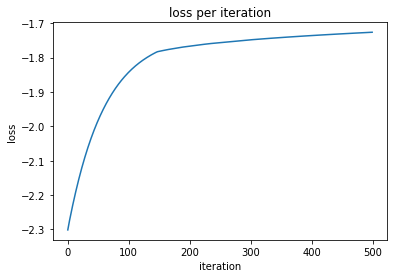

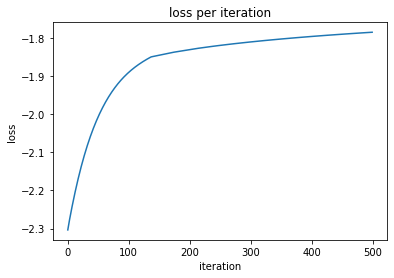

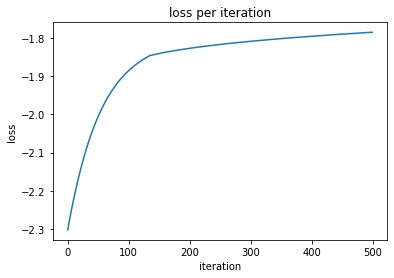

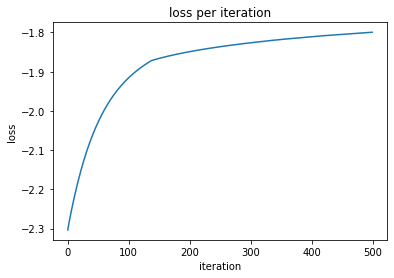

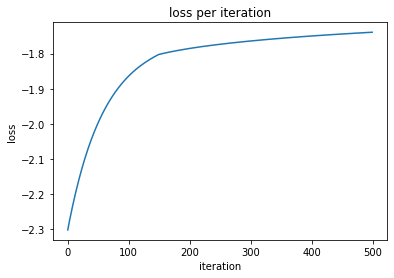

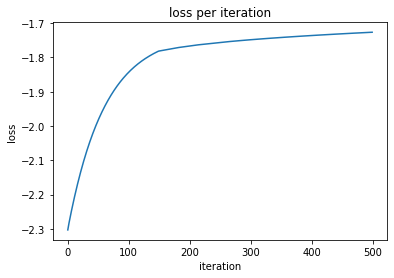

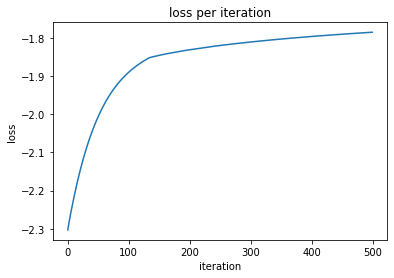

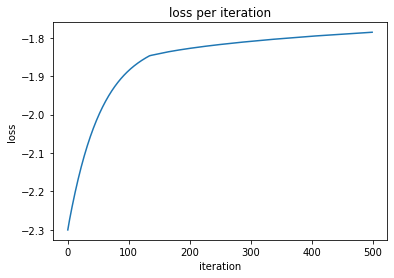

In [5]:
five_fold_cv = KFold(n_splits=5)

five_fold_losses = []
x = tfa
y = data.target
reg_factors = [0, 0.1, 0.01, 0.001]
# see which regularization factors work best
for reg in reg_factors:
    accuracies = []
    # five-fold cross-validation
    for train_index, test_index in five_fold_cv.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        weights, losses = train(X_train, y_train, lr=0.1, num_iters=500, reg=reg)
        # prediction accuracies
        res = predict(X_test, y_test, weights=weights)
        accuracies.append(res)
        five_fold_losses.append(losses)

    print(accuracies)

# plot sample losses (with 0.001 regularization term)
for i, loss in enumerate(five_fold_losses):
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('loss per iteration')
    plt.plot(loss)
    plt.savefig('loss_transform_' + '0'*(4-len(str(i))) + str(i) + '.png')
    plt.show()

### Without feature transform

[0.925, 0.8555555555555555, 0.9387186629526463, 0.9331476323119777, 0.8969359331476323]
[0.925, 0.8527777777777777, 0.9387186629526463, 0.9331476323119777, 0.8997214484679665]
[0.9222222222222223, 0.8777777777777778, 0.9387186629526463, 0.924791086350975, 0.8969359331476323]
[0.9277777777777778, 0.8527777777777777, 0.9387186629526463, 0.924791086350975, 0.8885793871866295]


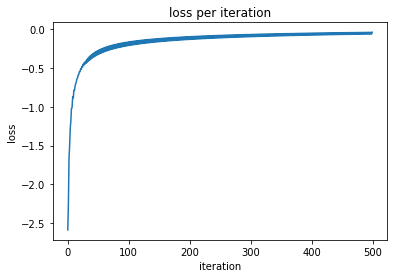

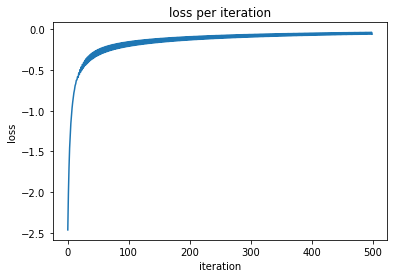

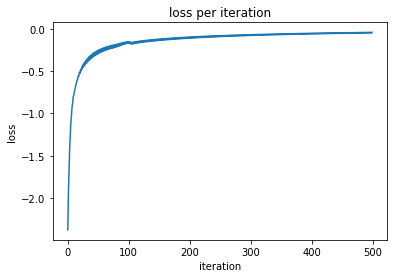

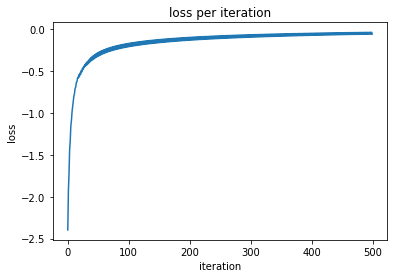

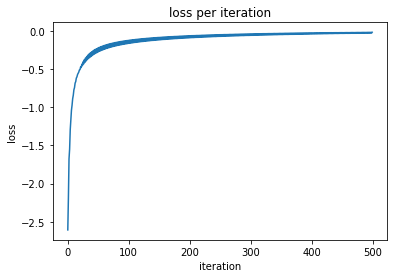

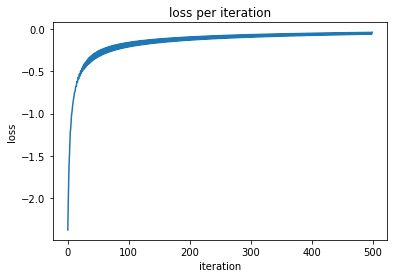

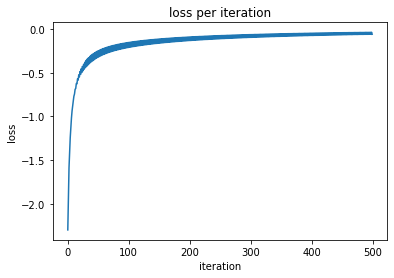

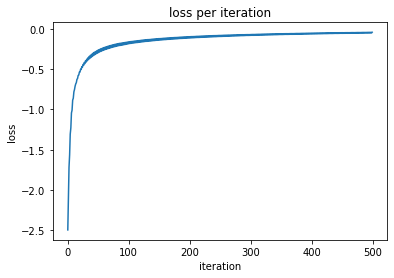

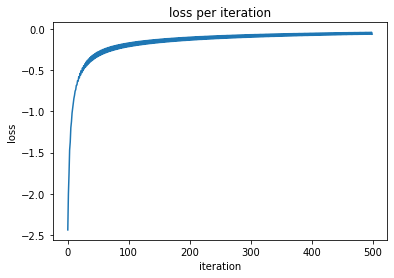

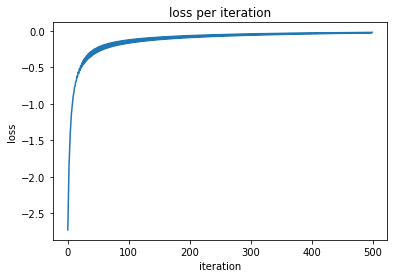

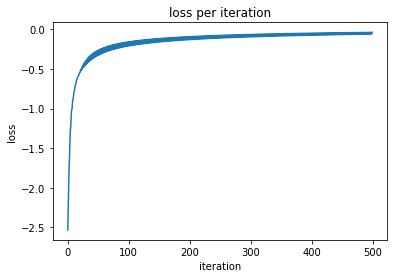

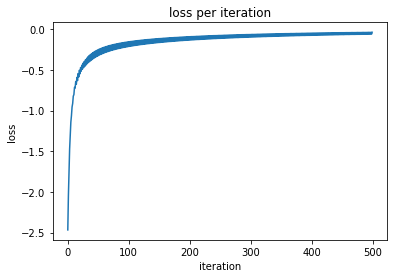

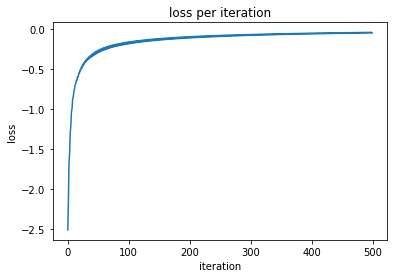

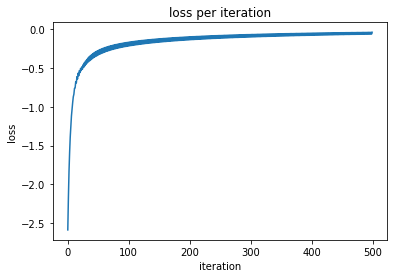

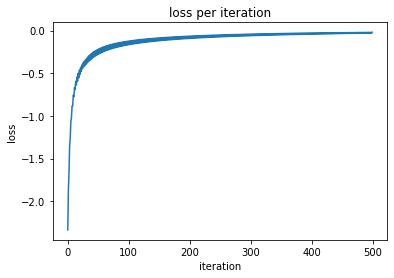

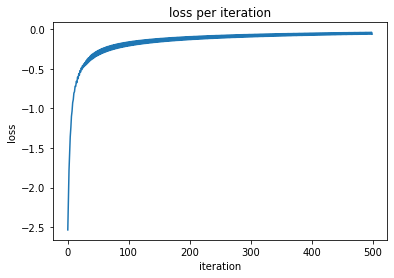

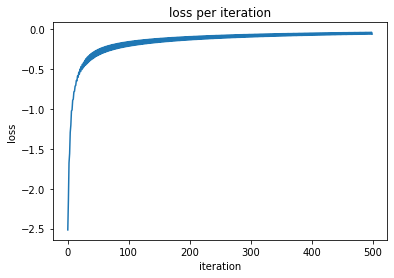

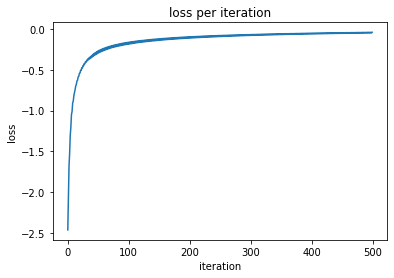

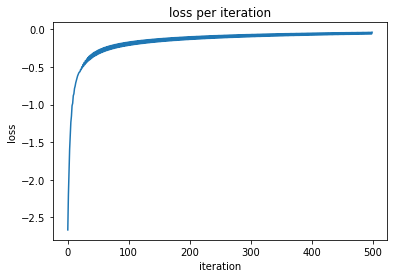

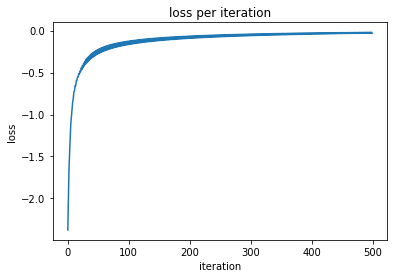

In [6]:
five_fold_cv = KFold(n_splits=5)

five_fold_losses = []
x = data.data
y = data.target
reg_factors = [0, 0.1, 0.01, 0.001]
# see which regularization terms work best
for reg in reg_factors:
    accuracies = []
    # do five-fold cross-validation
    for train_index, test_index in five_fold_cv.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        weights, losses = train(X_train, y_train, lr=0.1, num_iters=500, reg=reg)
        # prediction accuracies
        res = predict(X_test, y_test, weights=weights)
        accuracies.append(res)
        five_fold_losses.append(losses)

    print(accuracies)


for i, loss in enumerate(five_fold_losses):
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('loss per iteration')
    plt.plot(loss)
    plt.savefig('loss_no_transform_' + '0'*(4-len(str(i))) + str(i) + '.png')
    plt.show()